In [196]:
import polars as pl
import polars.selectors as cs
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
import plotly.io as pio

In [131]:
# import MNIST Data
raw_df = pl.read_csv('mnist_train_small.csv', separator=',')

In [132]:
# select the data
label = raw_df[:, 0]
data = raw_df[:, 1:]

# convert to tensor data
dataT = torch.tensor(data.to_numpy()).float()
labelT = torch.tensor(label.to_numpy()).long()

In [133]:
# split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(dataT, labelT, test_size=0.2, random_state=42)

In [134]:
# create the scaler
# X_train_scaler= FunctionTransformer(lambda x: (x / torch.max(X_train)), validate=True)
# X_test_scaler= FunctionTransformer(lambda x: (x / torch.max(X_test)), validate=True)
#
# # fit transform
# X_train_norm = torch.tensor(X_train_scaler.fit_transform(X_train), dtype=torch.float32)
# X_test_norm = torch.tensor(X_test_scaler.fit_transform(X_test), dtype=torch.float32)

In [135]:
# alternatively this is a better way of normalizing
# convert tensors to numpy
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

# initialize and fit scaler on training data
scaler = MinMaxScaler()

X_train_norm = torch.tensor(scaler.fit_transform(X_train_np), dtype=torch.float32)
X_test_norm = torch.tensor(scaler.transform(X_test_np), dtype=torch.float32)

In [136]:
# create dataset
train_dataset = TensorDataset(X_train_norm, y_train)
test_dataset = TensorDataset(X_test_norm, y_test)

# create dataloader
batchSize = 32
train_loader = DataLoader(train_dataset, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [137]:
# create the model class
class ANN(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        # create a dictionary to store the layers
        self.layers = nn.ModuleDict()

        # input layer
        self.layers['input'] = nn.Linear(784, nUnits)

        # generate the hidden layers
        for i in range(nLayers):
            self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

        # output layer
        self.layers['output'] = nn.Linear(nUnits, 10)

    # forward pass
    def forward(self, x):
        x = F.relu(self.layers['input'](x))

        # hidden layers
        # use the number of hiddenlayers directly from the ModuleDict
        for i in range(len(self.layers) -2 ): # -2 for input and output layers
            x = F.relu(self.layers[f"hidden{i}"](x))

        # return output layers
        x = F.log_softmax(self.layers['output'](x), dim=1)

        return x

In [138]:
# generate an instance of the model and inspect it
nUnitsPerLayer = 250
nLayers = 1
net = ANN(nUnitsPerLayer,nLayers)
net

ANN(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=250, bias=True)
    (hidden0): Linear(in_features=250, out_features=250, bias=True)
    (output): Linear(in_features=250, out_features=10, bias=True)
  )
)

In [139]:
# create model components
def createANNnet(train_loader, nUnits, nLayers, opti,learningRate=0.01):
    model = ANN(nUnits=nUnits, nLayers=nLayers)

    lossfunc = nn.CrossEntropyLoss()

    # create the opti that take in different optimizers
    optifunc = getattr(torch.optim, opti)
    optimizer = optifunc(model.parameters(), lr=learningRate)

    # define the scedular variables here - if part of the experiment then we move it to global variable
    epochStep=10
    gamma=1/2
    step_size = len(train_loader) * epochStep
    schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    return model, lossfunc, optimizer, schedular


In [140]:
# function to train the model
def trainModel(train_loader, test_loader, nUnits, nLayers, opti, learningRate, numepochs, toggleDynamic=True):
    # define an empty dataframe
    training_progress = pl.DataFrame(schema=[
        ('iteration', pl.Int64),
            ('epoch', pl.Int64),
            ('train_loss', pl.Float64),
            ('train_acc', pl.Float64),
            ('test_loss', pl.Float64),
            ('test_acc', pl.Float64),
            ('learning_rate', pl.Float64),

    ])
    iteration = 0

    # create the components
    model, lossfunc, optimizer, schedular = createANNnet(train_loader, nUnits, nLayers, opti, learningRate=learningRate)

    # get test data once (since we are using a test_loader that loads all data at once)
    X_testTL, y_testTL = next(iter(test_loader))

    # Early stopping parameters
    patience = 10
    best_loss = float('inf')
    no_improve_count = 0
    best_model = None
    import copy  # Add this import at the top of the file

    # training loop
    for epoch in range(numepochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = 0

        # iterate through the training batches
        for X_trainTL, y_trainTL in train_loader:
            yhat_train = model(X_trainTL)
            train_loss = lossfunc(yhat_train, y_trainTL)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if toggleDynamic:
                schedular.step()
                current_lrs = schedular.get_last_lr()[0]
            else:
                current_lrs = optimizer.param_groups[0]['lr']

            # get accuracy
            train_matches = (torch.argmax(yhat_train, axis=1) == y_trainTL).float()
            train_acc = 100 * torch.mean(train_matches)

            # number of batches - a counter for how many batches were processed in this epoch
            # epoch_train_loss = this is a running of the total of the training loss for all the batches in the current epoch
            # epoch_train_loss / num_batches  computes the average training loss per batch during the epoch
            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_acc.item()

            num_batches += 1

        # end of epoch: evaluate test Once
        model.eval()
        with torch.no_grad():
            yhat_test = model(X_testTL)
            test_loss = lossfunc(yhat_test, y_testTL)
            test_matches = (torch.argmax(yhat_test, axis=1) == y_testTL).float()
            test_acc = 100 * torch.mean(test_matches)

        # log single row per epoch
        new_row = pl.DataFrame([{
            'iteration': iteration,
            'epoch': epoch,
            'train_loss': epoch_train_loss / num_batches,
            'train_acc': epoch_train_acc / num_batches,
            'test_loss': test_loss.item(),
            'test_acc': test_acc.item(),
            'learning_rate': current_lrs
        }])

        # add row to the dataframe
        training_progress = pl.concat([training_progress, new_row])
        iteration += 1

        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss.item()
            no_improve_count = 0
            # Save best model
            best_model = copy.deepcopy(model)
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping at epoch {epoch+1} - No improvement for {patience} epochs")
                break

        # this matches with the epoch step
        if epoch % 10 == 0 or epoch == numepochs - 1:
            print(
                f"Epoch {epoch+1}/{numepochs} - "
                f"Training: Loss={epoch_train_loss / num_batches:.4f}, "
                f"Accuracy={epoch_train_acc / num_batches:.2f}% | "
                f"Testing: Loss={test_loss.item():.4f}, "
                f"Accuracy={test_acc.item():.2f}% | "
                f"Learning Rate: {current_lrs:.6f}"
            )

    # Return the best model instead of the last model
    return training_progress, best_model if best_model is not None else model



In [141]:
# define the global variable
numepochs = 100
nUnits = 250
nLayers = 2

test_optimizers = ['SGD', 'RMSprop', 'Adam']
trained_models = {}
learningRates = np.logspace(np.log10(.0001),np.log10(.1),6)




In [142]:
all_results = []

for opti in test_optimizers:
    for lr in learningRates:
        print(f"Training with Optimizer: {opti} and Learning Rate:{round(lr, 4)}")

        training_progress, model = trainModel(train_loader, test_loader, nUnits, nLayers, opti=opti, learningRate=lr, numepochs=numepochs, toggleDynamic=False)

        # annotate the test parameters
        training_progress = training_progress.with_columns(
            optimizer=pl.lit(opti),
            learning_rates=pl.lit(lr).cast(pl.Float64)
        )

        # append the returning dataframes in each all_results lists
        all_results.append(training_progress)
        trained_models[opti] = model

        print(f"Final test accuracy with {opti} : {training_progress['test_acc'].tail(1)[0]}")

# concat the dataframes in the all_list
combined_results = pl.concat(all_results)

Training with Optimizer: SGD and Learning Rate:0.0001
Epoch 1/100 - Training: Loss=2.3032, Accuracy=11.59% | Testing: Loss=2.3032, Accuracy=12.15% | Learning Rate: 0.000100
Epoch 11/100 - Training: Loss=2.2997, Accuracy=14.73% | Testing: Loss=2.2997, Accuracy=14.90% | Learning Rate: 0.000100
Epoch 21/100 - Training: Loss=2.2962, Accuracy=17.85% | Testing: Loss=2.2962, Accuracy=17.73% | Learning Rate: 0.000100
Epoch 31/100 - Training: Loss=2.2924, Accuracy=20.74% | Testing: Loss=2.2925, Accuracy=20.83% | Learning Rate: 0.000100
Epoch 41/100 - Training: Loss=2.2883, Accuracy=23.52% | Testing: Loss=2.2883, Accuracy=23.93% | Learning Rate: 0.000100
Epoch 51/100 - Training: Loss=2.2836, Accuracy=25.73% | Testing: Loss=2.2836, Accuracy=26.07% | Learning Rate: 0.000100
Epoch 61/100 - Training: Loss=2.2781, Accuracy=28.81% | Testing: Loss=2.2781, Accuracy=29.85% | Learning Rate: 0.000100
Epoch 71/100 - Training: Loss=2.2717, Accuracy=35.65% | Testing: Loss=2.2716, Accuracy=36.72% | Learning Ra

In [167]:
# inspect the data
combined_results.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate,optimizer,learning_rates
i64,i64,f64,f64,f64,f64,f64,str,f64
0,0,2.303184,11.591934,2.303159,12.15,0.0001,"""SGD""",0.0001
1,1,2.302846,11.923848,2.302818,12.25,0.0001,"""SGD""",0.0001
2,2,2.302486,12.224449,2.302477,12.5,0.0001,"""SGD""",0.0001
3,3,2.302141,12.556363,2.302137,12.875,0.0001,"""SGD""",0.0001
4,4,2.301808,12.938377,2.301796,13.249999,0.0001,"""SGD""",0.0001


In [174]:
grouped_results = (
    combined_results
    .drop('learning_rate')
    .group_by('optimizer', 'learning_rates', 'epoch')
    .agg(
        cs.numeric().mean().name.prefix('mean_')
    )
    .sort(['optimizer', 'learning_rates', 'epoch'], descending=[True, False, False])
)

In [176]:
# inspect the group results
grouped_results

optimizer,learning_rates,epoch,mean_iteration,mean_train_loss,mean_train_acc,mean_test_loss,mean_test_acc
str,f64,i64,f64,f64,f64,f64,f64
"""SGD""",0.0001,0,0.0,2.303184,11.591934,2.303159,12.15
"""SGD""",0.0001,1,1.0,2.302846,11.923848,2.302818,12.25
"""SGD""",0.0001,2,2.0,2.302486,12.224449,2.302477,12.5
"""SGD""",0.0001,3,3.0,2.302141,12.556363,2.302137,12.875
"""SGD""",0.0001,4,4.0,2.301808,12.938377,2.301796,13.249999
…,…,…,…,…,…,…,…
"""Adam""",0.1,7,7.0,2.314826,10.452154,2.311884,9.425
"""Adam""",0.1,8,8.0,2.313241,10.145291,2.319351,10.3
"""Adam""",0.1,9,9.0,2.312907,10.013778,2.310399,10.125


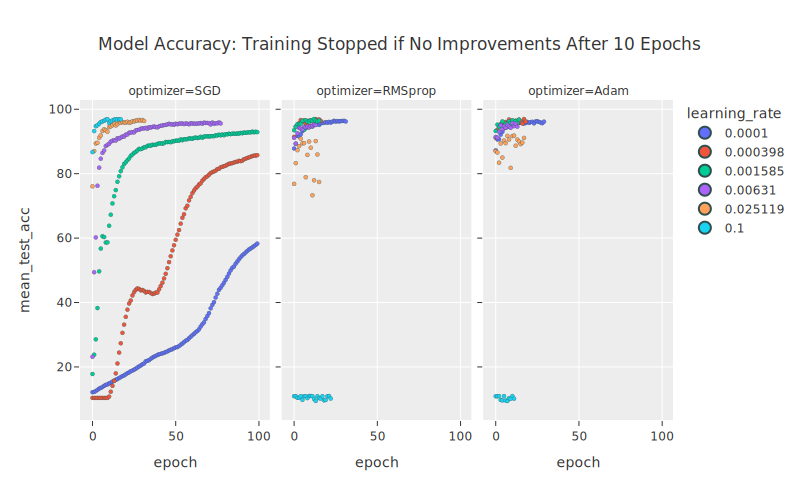

In [224]:
fig = px.scatter(
    grouped_results,
    x='epoch',
    y='mean_test_acc',
    color=grouped_results.select(pl.col('learning_rates').round(6).cast(pl.String)).to_series(),
    facet_col='optimizer',
    title='Model Accuracy: Training Stopped if No Improvements After 10 Epochs',
    labels={'color' : 'learning_rate'}

)

fig.update_layout(template='ggplot2', width=800, legend=dict(itemsizing='constant'))
fig.update_traces(marker=dict(size=4, line=dict(width=0.3, color='darkslategrey')))
fig.show(renderer='svg')

In [210]:
grouped_results.filter(pl.col('mean_train_loss').lt(500))

optimizer,learning_rates,epoch,mean_iteration,mean_train_loss,mean_train_acc,mean_test_loss,mean_test_acc
str,f64,i64,f64,f64,f64,f64,f64
"""SGD""",0.0001,0,0.0,2.303184,11.591934,2.303159,12.15
"""SGD""",0.0001,1,1.0,2.302846,11.923848,2.302818,12.25
"""SGD""",0.0001,2,2.0,2.302486,12.224449,2.302477,12.5
"""SGD""",0.0001,3,3.0,2.302141,12.556363,2.302137,12.875
"""SGD""",0.0001,4,4.0,2.301808,12.938377,2.301796,13.249999
…,…,…,…,…,…,…,…
"""Adam""",0.1,7,7.0,2.314826,10.452154,2.311884,9.425
"""Adam""",0.1,8,8.0,2.313241,10.145291,2.319351,10.3
"""Adam""",0.1,9,9.0,2.312907,10.013778,2.310399,10.125


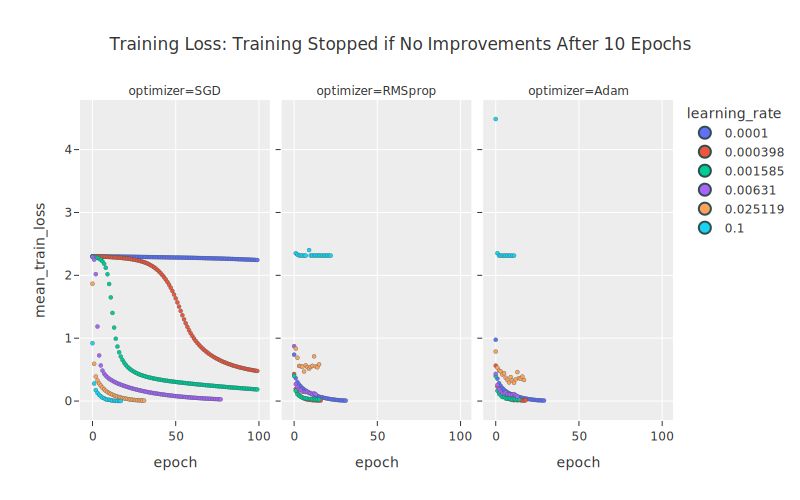

In [223]:
fig = px.scatter(
    grouped_results.filter(pl.col('mean_train_loss') < 10),
    x='epoch',
    y='mean_train_loss',
    color=grouped_results.filter(pl.col('mean_train_loss') < 10).select(pl.col('learning_rates').round(6).cast(pl.String)).to_series(),
    facet_col='optimizer',
    title='Training Loss: Training Stopped if No Improvements After 10 Epochs',
    labels={'color' : 'learning_rate'}

)

fig.update_layout(template='ggplot2', width=800, legend=dict(itemsizing='constant'))
fig.update_traces(marker=dict(size=4, line=dict(width=0.3, color='darkslategrey')))
fig.show(renderer='svg')

## Interpretation:
* SGD does well for large learning rates
* RMSprop and Adam are similar in performance but does terribly at larget learning rate
    * they scale the learning rate as a function so because of that they have built-in dynamic learning rate
    * thus, Adam and RMSprop tend to do better when we initialize the learning rate to something small
* SGD when learning rate is too small the it runs into vanishing gradient